# Evaluate different PDFs on an experimental data set

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import openturns as ot
import openturns.viewer as viewer
from os import sep, sys
import netCDF4 as nc
colors=['#002d74', '#e85113', '#1fa12e', '#c9d200', '#f49e00', '#006ab3', '#3381ff', '#f2855a', '#54de64']

## Uncertain roughness height, velocity and direction at hub height

The chosen distributions here are arbitrary, and allow exploring the propagation differences in the tested models.

In [58]:
#Define uncertain variables and PDF parameters
uq_var_names = ["direction","speed","z0"]
uq_var_units = ['N-degree', 'm/s', 'm']
uq_var_number = len(uq_var_names)
mean_dir = 270.0 ; std_dir = 3.0
mean_vel = 10.0 ; std_vel = 0.05*mean_vel
min_z0 =  1e-5 ; max_z0 =  1e-2

#Sample
sample_size = 1000  #effective sample size with dim=3 would be 100. Sample larger.
ot_collection = ot.DistributionCollection(uq_var_number)
ot_collection_description = ot.Description(uq_var_number)
ot_collection[0] = ot.Normal(mean_dir,std_dir) #wind_dir dir_hub
ot_collection[1] = ot.Normal(mean_vel,std_vel) #wind_velocity u_hub
ot_collection[2] = ot.Uniform(min_z0,max_z0) #roughness_height z0
#
ot_input_PDF = ot.ComposedDistribution(ot_collection, ot.IndependentCopula(uq_var_number)) #can choose other copulas
ot_MC_design = ot.MonteCarloExperiment(ot_input_PDF, sample_size) #can choose another design
ot_sample = ot_MC_design.generate()

## Shear velocity and Turbulence intensity deduced by literature formulas

The shear velocity is calculated using the Charnok (1955) formula:
\begin{equation}
u_* = \sqrt{\frac{g z_0}{\alpha}}
\end{equation}

where $\alpha=0.011$ for open ocean conditions. This parameter could also be considered as uncertain to account for the uncertainty in the above formula, but is here taken as deterministic.

Then, the standard deviation of the velocity is deduced from the shear velocity using the Stull (1988) formula as:
\begin{equation}
\sigma_u = 6.25 u_*^2
\end{equation}

Turbulence Intensity (TI) is then estimated as $\sigma_u/u$.  Note that the latter is only used for engineering models, and the CFD-RANS model uses the $k-\epsilon$ closure for turbulence, relying on the Louis formula to construct the $k$ and $\epsilon$ profiles that are then used as Boundary Conditions (BC) and Initial Conditions (IC).

In [59]:
#Generate other dependent variables and store sample : here u_* and TI
var_names = uq_var_names.copy()
var_names.append('TI')
var_names.append('ustar')
var_units = uq_var_units.copy()
var_units.append('')
var_units.append('m/s')
#
sample_array = np.zeros((sample_size,len(var_names)))
sample_array[:,:uq_var_number] = np.array(ot_sample)
#
#sample_array[:,2] = np.exp(sample_array[:,2]) #costum for log uniform
#
z0_sample = sample_array[:,2]
ustar_sample = np.sqrt(9.81*z0_sample/0.011) #Charnok 1955 #here 0.011 is uncertain.. could use copula instead
sigma_u_sample = 6.25*(ustar_sample**2) #Stull 1988
u_sample = sample_array[:,1] ; TI_sample = sigma_u_sample/u_sample # as done for cup anemometers
sample_array[:,3] =  TI_sample
sample_array[:,4] =  ustar_sample

## Checking the samples using plots

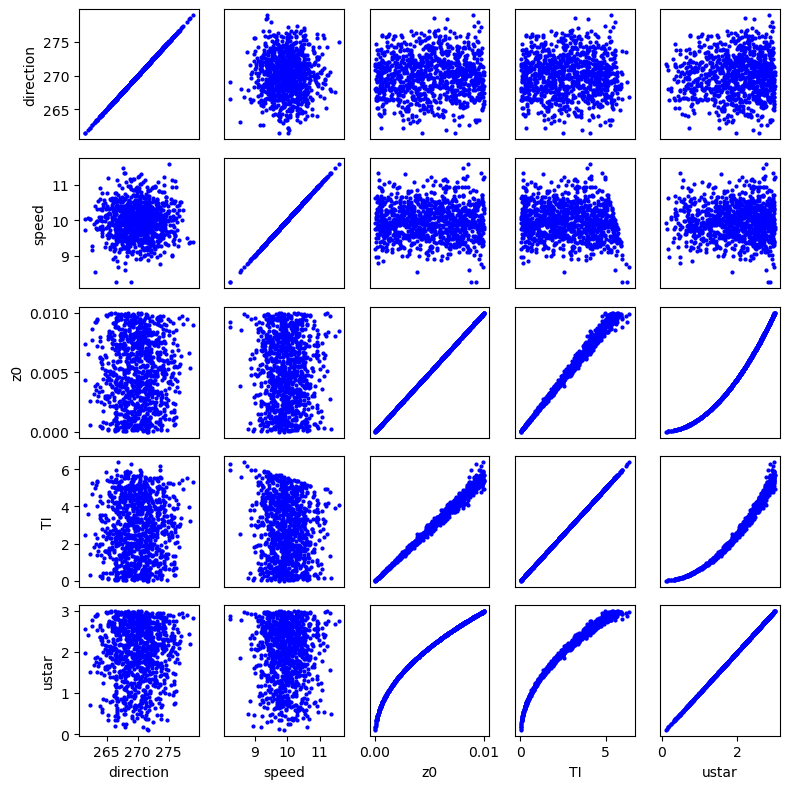

In [60]:
variables_to_scatter = sample_array
legend_varnames = var_names
#
nvar=len(legend_varnames)
fig, axs = plt.subplots(nrows=nvar,ncols=nvar, figsize=(8, 8))
for i in range(nvar):
    for j in range(nvar):
        # Plot data in each subplot
        axs[i, j].plot(variables_to_scatter[:,j], variables_to_scatter[:,i], marker='o', \
                       markersize=2, linestyle='None', color='blue')
        #axs[i, j].set_title('Scatter Plot '+str(i)+' '+str(j))
        #
        axs[i, j].tick_params(axis="x",which="both",labelbottom=False, bottom=False, top=False)
        axs[i, j].tick_params(axis="y",which="both",labelleft=False, left=False, right=False)
        if(j==0):
            axs[i, j].set(ylabel=legend_varnames[i])
            axs[i, j].tick_params(axis="y",which="both",labelleft=True, left=True)
        if(i==nvar-1):
            axs[i, j].set(xlabel=legend_varnames[j])
            axs[i, j].tick_params(axis="x",which="both",labelbottom=True, bottom=True)

plt.tight_layout()
plt.show()

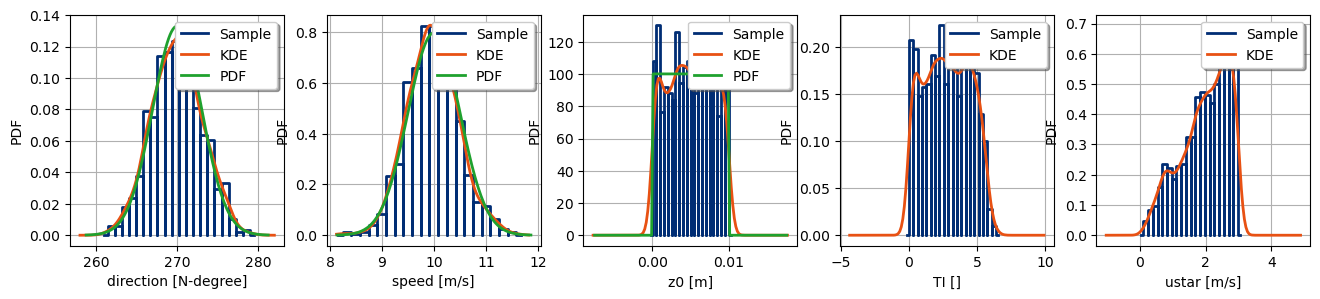

In [61]:
fig = plt.figure(figsize=(16, 3))
for i in range(nvar):
    histogram = ot.HistogramFactory().buildAsHistogram(ot.Sample(sample_array)[:,i], 20)
    graph = histogram.drawPDF()
    legend = ["Sample"]
    graph.setColors(colors)
    
    ##custom for log uniform
    #if(i==2): 
    #    graph.setLogScale(1)
    #    
    kernel = ot.KernelSmoothing(ot.Normal())
    fitted_KDE = kernel.build(ot.Sample(sample_array)[:,i])
    graph.add(fitted_KDE.drawPDF())
    legend.append("KDE")
    
    if(i<len(uq_var_names)):
        graph.add(ot_collection[i].drawPDF())
        legend.append("PDF")
    #
    graph.setLegends(legend)
    graph.setColors(colors)
    graph.setXTitle(var_names[i] + ' [' + var_units[i] + ']') ; graph.setYTitle("PDF") ; graph.setTitle("")
    #
    ax_1 = fig.add_subplot(1, nvar, i+1)
    _ = viewer.View(graph, figure=fig, axes=[ax_1])

### Reminder about non parametric PDF fitting (Kernel Density Estimations) used above

An empirical PDF can be fitted on the data using Kernel Density Estimates (KDE), also called Kernel Smoothing. This method is prefered when the sample size is big enough (measurements are considered sufficient).

KDE is a continuous approximation of the variables histogram, consisting in a superposition of standard PDFs in the variables space in order to cover all density variations. The Kernel designates the used standard PDF, denoted K. 

For a random variable X with realizations $[x^(1),\dots,x^(n)]$, KDE is written as:
\begin{equation}
\widetilde{f_X}(x) = \dfrac{1}{n\times h_K}\sum_{i=1}^n K\left(\dfrac{x-x^{(i)}}{h_k}\right)
\end{equation}

where $\widetilde{f_X}$ is an estimate of the true density $f_X$, that converges when increasing the sample size, whatever the chosen kernel. The parameter $h_K$ is called the bandwidth. In dimension 1, when using Gaussian Kernels, the optimal bandwidth can for example defined by the Silverman rule (computed using interquartile ranges).

It is advised to use symmetric PDFs as kernels to avoid discontinuities.

### Write in a "time series" netCDF

In [62]:
time_series_like_file_name = "Stochastic_atHubHeight.nc"
write_timeseries_nc = False
if(write_timeseries_nc):
    ds = nc.Dataset(time_series_like_file_name, 'w', format='NETCDF4')
    #
    #Declare dimensions
    time = ds.createDimension('time', sample_size) #event which is randomly drawn above. could as well be time.
    time = ds.createVariable('time', 'f4', ('time',))
    time.units = 'occurence number starting from 0'
    time[:] = np.arange(sample_size)
    #
    #Declare variables
    ncdf_var = []
    for i in range(nvar):
        ncdf_var.append(ds.createVariable(var_names[i], 'f4', ('time')))
        ncdf_var[i].units = var_units[i]
        ncdf_var[i][:] = sample_array[:,i]
    #    
    ds.close()

### Read the netCDF file for verification

In [63]:
time_series_like_file_name = "Stochastic_atHubHeight.nc"
nc_file = nc.Dataset(time_series_like_file_name)
nc_file_var_names = [key for key in nc_file.variables.keys()] 
nc_file_var_dimensions = nc_file.variables[nc_file_var_names[1]].dimensions
nc_file_var_shape = nc_file.variables[nc_file_var_names[1]].shape
print("Variables are : ", nc_file_var_names) # get all variable names
print("Dimensions of variable 1 are : ", nc_file_var_dimensions) #get dimensions of var 1
print("Shape of variable 1 is : ", nc_file_var_shape) #get shape of var 1

Variables are :  ['time', 'direction', 'speed', 'z0', 'TI', 'ustar']
Dimensions of variable 1 are :  ('time',)
Shape of variable 1 is :  (1000,)


### Option for vertical profile : Add new stability dimension and generate Nieuwstadt profiles

#### explanation by Antoine Mathieu (EDF)
Add to overleaf.

The profiles of the dimensionless velocity components and potential temperature are retrieved by integrating over the boundary layer the following expressions:
\begin{equation}
    \dfrac{\partial u^+}{\partial z} = \dfrac{1}{\kappa z}\varphi_m\left(\zeta\right)\left(1-\dfrac{z}{H}\right)^{\frac{\alpha}{2}-1} cos\left[\dfrac{\sqrt{\alpha(\alpha+2)}}{2}ln\left(1-\dfrac{z}{H}\right)\right]
\end{equation}
\begin{equation}
    \dfrac{\partial v^+}{\partial z} = \dfrac{1}{\kappa z}\varphi_m\left(\zeta\right)\left(1-\dfrac{z}{H}\right)^{\frac{\alpha}{2}-1} sin\left[\dfrac{\sqrt{\alpha(\alpha+2)}}{2}ln\left(1-\dfrac{z}{H}\right)\right]
\end{equation}
with $u^+=u/u_*$, $v^+=v/u_*$ and $\theta^+=\theta/\theta_*$, where $u_*$ is the friction velocity, $\theta_*=u_*^2\theta_0/\kappa g L$ a temperature scale, $\theta_0$ the ground temperature, $H$ the boundary layer height and $\kappa$ the von Karman constant. 

The coefficient $\alpha$ is a model parameter here set to 1 (sensitivity tests have better profile conservation in the simulation domain with this value). Above $H$, the velocity is equal to the geostrophic wind speed and the temperature profile is a function of a temperature difference for the capping inversion $\Delta\theta=5$K, a capping inversion thickness $\Delta h=100$m and a slope of the upper stable profile $\Gamma=4$K/km.

For a given Monin-Obukhov's length $L$ and model parameter $\alpha$, the unknown boundary layer height $H$, friction velocity $u_*$ and temperature scale $\theta_*$ are computed using an iterative method. The model of Zilitinkevich (1972) is used for the boundary layer height following:
\begin{equation}
    H=c_s\sqrt{\dfrac{u_*L}{f}}
\end{equation}
with $c_s=0.4$ a model constant and $f$ the Coriolis parameter. The velocity scale $u_*$ is estimated to have the velocity at the top of the boundary layer matching the geostrophic wind speed.

Once converged values of $H$ and $u_*$ are obtained, profiles of turbulent kinetic energy $k$ and dissipation rate of turbulent kinetic energy $\varepsilon$ together with the heat flux at the bottom $q_0$ are computed using the expressions:
\begin{equation}
    k = \dfrac{u_*^2}{2}\sqrt{\dfrac{d(\varphi_m(\zeta)-\zeta)}{\varphi_h(\zeta)\left(W_0+W_1\dfrac{\varphi_m(\zeta)}{\varphi_m(\zeta)-\zeta}-\dfrac{1-a_1}{C_\theta}\dfrac{\zeta}{\varphi_m(\zeta)-\zeta}\right)}}\left(1-\dfrac{z}{H}\right)^{\frac{\alpha}{2}+1}
\end{equation}
\begin{equation}
    \varepsilon = \dfrac{u_*^3}{\kappa z}\left(\varphi_h(\zeta)-\zeta\right)\left(1-\dfrac{z}{H}\right)^\alpha
\end{equation}
\begin{equation}
    q_0 = -\rho_0C_pu_*\theta_*
\end{equation}
with $C_p$ the thermal capacity and model coefficients given by:
\begin{equation}
    \left\{
    \begin{array}{ccc}
      d=9.7, & \quad W_0=\dfrac{1}{3}-\dfrac{2}{3C}+\dfrac{2}{C}+\dfrac{4}{3}\dfrac{C_3}{3}, & \quad W_1=\dfrac{2}{3}\dfrac{C_2}{C}-\dfrac{2}{C}-\dfrac{4}{3}\dfrac{C_3}{3} \\
      C_\theta=1.4,&  \quad a_1=\dfrac{1}{3}+\dfrac{3}{2}Ri^2-Ri^3,  &  \quad C=6\\
      C_2=0.1, &  \quad C_3=-0.8 &  \quad
    \end{array}
    \right.  
\end{equation}

In [64]:
from meteo_profile import *

#Sample Monin Obukhov Length
min_LMO = 5.0 ; max_LMO = 1000.0
ot_sample_LMO = ot.Uniform(min_LMO, max_LMO).getSample(sample_size)
#
wind_dir_sample = nc_file.variables["direction"][:]
wind_velocity_sample = nc_file.variables["speed"][:]
z0_sample = nc_file.variables["z0"][:]

In [ ]:
# temperature profile parameters
T0 = 288.15      # Bottom atmospheric temperature (K)
dh = 100         # capping inversion thickness (m)
dtheta = 5       # capping-inversion height
gamma = 0.004     # free-atmosphere lapse rate

# velocity profile parameters
G = 12          # geostrophic wind speed (m/s)
lat = 55        # latitude

# vertical grid
Lz = 1700             # domain height (m)
Nz = 1000               # grid point (-)
dz = Lz/Nz            # grid resolution (m)


profile_sample_size = 100 #sample_size
z_profile = np.linspace(np.max(z0_sample[:profile_sample_size]), Lz-dz/2, Nz, endpoint=True)
u_sample = np.zeros((profile_sample_size, Nz)) ; v_sample = np.zeros((profile_sample_size, Nz))
pottemp_sample = np.zeros((profile_sample_size, Nz))
tke_sample = np.zeros((profile_sample_size, Nz)) ; epsilon_sample = np.zeros((profile_sample_size, Nz))
for j in range(profile_sample_size):
    print("fitting Nieuwstadt profile "+str(j+1)+"/"+str(profile_sample_size) + \
          " for lmo,z0,dir="+str(ot_sample_LMO[j,0])+","+str(z0_sample[j])+","+str(wind_dir_sample[j]),end="\r")
    pottemp_sample[j,:], u_sample[j,:], v_sample[j,:], \
        tke_sample[j,:], epsilon_sample[j,:] = Nieuwstadt_profile(altitude=z_profile, \
                                          Lmo=ot_sample_LMO[j,0], z0=z0_sample[j], \
                                          T0=T0, dh=dh, dtheta=dtheta, gamma=gamma, \
                                          G=G, lat=lat, \
                                          hub_height=119.0, hub_dir=wind_dir_sample[j])

In [94]:
#
uq_var_names = ["speed","direction","k","epsilon","pottemp","TI","z0"]
uq_var_units = ['m/s', 'm/s', 'm^2/s^-2', 'm^2/s^-3', 'm', '', 'K']
uq_nvar = len(uq_var_names)
#
speed_sample = np.zeros((profile_sample_size, Nz))
direction_sample = np.zeros((profile_sample_size, Nz))
for j in range(profile_sample_size):
    speed_sample[j,:] = np.sqrt(u_sample[j,:]**2+v_sample[j,:]**2)
    speed_sample[j,:] = 10.
    direction_sample[j,:] = 270.0 - np.arctan2(v_sample[j,:],u_sample[j,:])
#   
zprofile_sample_array =  np.zeros((profile_sample_size, Nz, uq_nvar-1))
zprofile_sample_array[:,:,0] = speed_sample ; zprofile_sample_array[:,:,1] = direction_sample
zprofile_sample_array[:,:,2] = tke_sample ; zprofile_sample_array[:,:,3] = epsilon_sample
zprofile_sample_array[:,:,4] = pottemp_sample
zprofile_sample_array[:,:,5] = np.sqrt((2./3.)*tke_sample)/np.sqrt(speed_sample)
#
zprofile_time_series_like_file_name = "Stochastic_vertical_profiles.nc"
write_zprofile_timeseries_nc = True
if(write_zprofile_timeseries_nc):
    ds = nc.Dataset(zprofile_time_series_like_file_name, 'w', format='NETCDF4')
    #
    #Declare dimensions
    time = ds.createDimension('time', profile_sample_size) #event which is randomly drawn above. could as well be time.
    time = ds.createVariable('time', 'f4', ('time',))
    time.units = 'occurence number starting from 0'
    time[:] = np.arange(profile_sample_size)
    #    
    height = ds.createDimension('z', Nz) #event which is randomly drawn above. could as well be time.
    height = ds.createVariable('z', 'f4', ('z',))
    height.units = 'm'
    height[:] = z_profile
    #
    #Declare variables
    ncdf_var = []
    for i in range(uq_nvar-1):
        ncdf_var.append(ds.createVariable(uq_var_names[i], 'f4', ('time', 'z')))
        ncdf_var[i].units = uq_var_units[i]
        ncdf_var[i][:,:] = zprofile_sample_array[:,:,i]
    #    
    ncdf_var.append(ds.createVariable(uq_var_names[-1], 'f4', ('time')))
    ncdf_var[i].units = uq_var_units[-1]
    ncdf_var[i][:] = z0_sample
    #    
    ds.close()

### Read the netcdf for verification

In [98]:
zprofile_time_series_like_file_name = "Stochastic_vertical_profiles.nc"
zprofile_nc_file = nc.Dataset(zprofile_time_series_like_file_name)
zprofile_nc_file_var_names = [key for key in zprofile_nc_file.variables.keys()] 
zprofile_nc_file_var_dimensions = zprofile_nc_file.variables[zprofile_nc_file_var_names[2]].dimensions
zprofile_nc_file_var_shape = zprofile_nc_file.variables[zprofile_nc_file_var_names[2]].shape
print("Variables are : ", zprofile_nc_file_var_names) # get all variable names
print("Dimensions of variable 2 are : ", zprofile_nc_file_var_dimensions) #get dimensions of var 1
print("Shape of variable 2 is : ", zprofile_nc_file_var_shape) #get shape of var 1

Variables are :  ['time', 'z', 'speed', 'direction', 'k', 'epsilon', 'pottemp', 'TI', 'z0']
Dimensions of variable 2 are :  ('time', 'z')
Shape of variable 2 is :  (100, 1000)


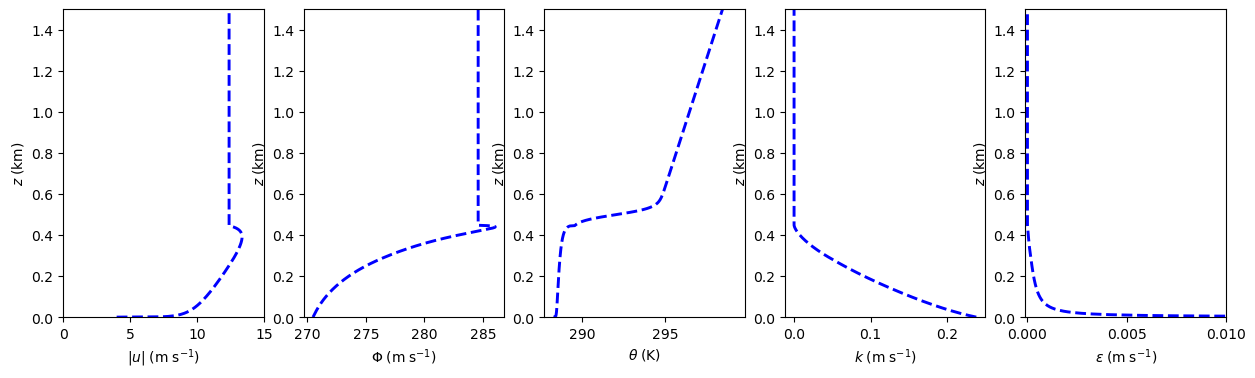

In [9]:
linewidth = 2.1
fig, ax = plt.subplots(1, 5, figsize=(15, 4))

# u velocity
#ax[0].plot(uprof, altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
#ax[0].set_xlabel('$u \; (\mathrm{m} \; \mathrm{s}^{-1})$')
# u magnitude
ax[0].plot(np.sqrt(uprof**2+vprof**2), altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
ax[0].set_xlabel('$|u| \; (\mathrm{m} \; \mathrm{s}^{-1})$')
ax[0].set_ylabel('$z \; (\mathrm{km})$')
ax[0].set_ylim([0, 1.5])
ax[0].set_xlim([0, 15])

# v velocity
#ax[1].plot(vprof, altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
#ax[1].set_xlabel('$v \; (\mathrm{m} \; \mathrm{s}^{-1})$')
# u direction
ax[1].plot(270.0-np.arctan2(vprof,uprof)*180/np.pi, altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
ax[1].set_xlabel('$\Phi \; (\mathrm{m} \; \mathrm{s}^{-1})$')

ax[1].set_ylabel('$z \; (\mathrm{km})$')
ax[1].set_ylim([0, 1.5])
#ax[1].set_xlim([-4, 4])

# potential temperature
ax[2].plot(thetaprof, altitude/1000, color='blue', linewidth=linewidth,
              linestyle='--')
ax[2].set_xlabel(r'$\theta \; (\mathrm{K})$')
ax[2].set_ylabel('$z \; (\mathrm{km})$')
ax[2].set_ylim([0, 1.5])
#axarr[2].set_xlim([288,290])

# tke
ax[3].plot(tke, altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
#axarr[3].set_xscale('log')
ax[3].set_xlabel('$k \; (\mathrm{m} \; \mathrm{s}^{-1})$')
ax[3].set_ylabel('$z \; (\mathrm{km})$')
ax[3].set_ylim([0, 1.5])
# axarr[3].set_xlim([6.5,10.2])

# eps
ax[4].plot(epsilon, altitude/1000, color='blue', linewidth=linewidth, linestyle='--')
#axarr[4].set_xscale('log')
ax[4].set_xlabel('$\epsilon \; (\mathrm{m} \; \mathrm{s}^{-1})$')
ax[4].set_ylabel('$z \; (\mathrm{km})$')
ax[4].set_ylim([0, 1.5])
ax[4].set_xlim([-0.0001, 1e-2])

plt.show()